In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import shap #Feature importance graph
import warnings

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from catboost import Pool, CatBoostRegressor, cv #catboost
from sklearn.model_selection import train_test_split #as it is

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warning from sklearn and seaborn

In [3]:
train = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
train.SalePrice.values


array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [6]:
test.shape

(1459, 80)

In [7]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


# Deleting outliers

In [8]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


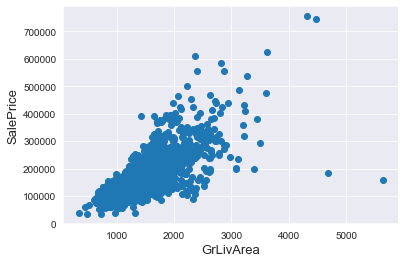

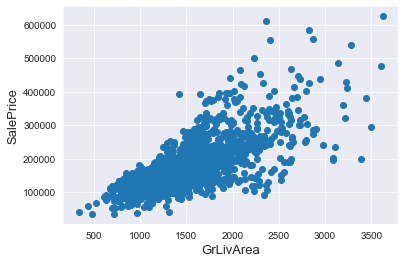

In [9]:
#show outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


# Check and normalize the distribution


 mu = 180151.23 and sigma = 76670.25



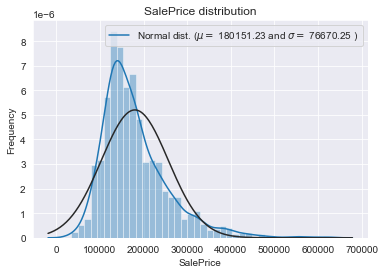

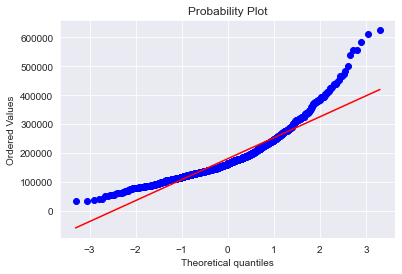

In [10]:
#SalePrice exploration
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


# The numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# Feature engineering

In [10]:
#concatenate data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))



all_data size is : (2915, 79)


In [11]:
#calculate % of missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


<AxesSubplot:>

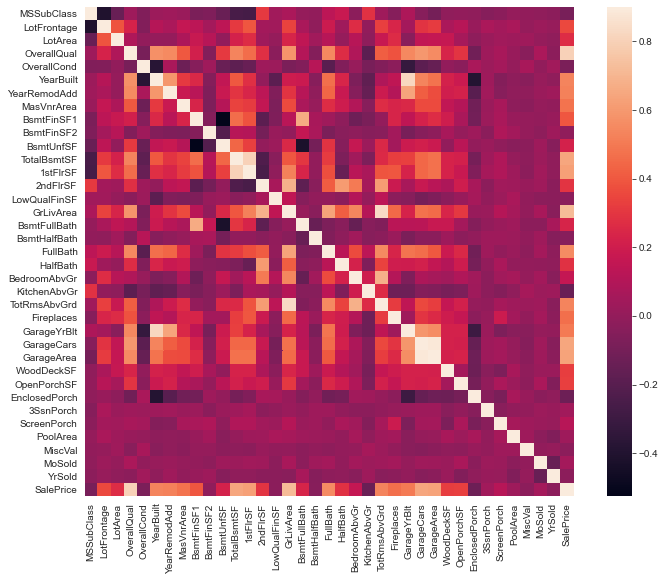

In [12]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [13]:
#fill up missing values


#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#Check whether it should be None or 0
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt','MasVnrArea', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MasVnrType','Electrical','Exterior1st', 'Exterior2nd','MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#for Functional NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [14]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [15]:
#Transforming some numerical variables that are really categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(int)

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


#Since area features are really important we can add one more as a sum.Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Getting new train and test set

In [16]:
#rows from train dataset
train = all_data[:ntrain]
#rows since train dataset (test)
test = all_data[ntrain:]

In [17]:
y_train

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

# Catboost

In [18]:
#Select all the categorial features

feat= np.where(train.dtypes == object)[0]
#split
X_train, X_val, y_train, y_val = train_test_split(train, y_train, train_size=0.8, random_state=1234)

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=feat)
val_pool = Pool(X_val, y_val,
                 cat_features=feat) 

test_pool = Pool(test, cat_features = feat)


# Parameter tuning

# model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.05, 0.08, 0.1],
        'max_depth': [4, 6,8, 10],
        'l2_leaf_reg': [1, 3, 6, 8, 9],
        'random_strength': [0.5, 1, 2, 4]}

                                   
                                     
randomized_search_result = model.randomized_search(grid,
                                                   train_pool,
                                                   plot=True)


In [19]:
model = CatBoostRegressor(loss_function='RMSE', 
                                    use_best_model = True,
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.08,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide')



In [20]:
model.fit(train_pool, eval_set = val_pool)
print ('Model is fitted:', model.is_fitted())
print ('Model params:', model.get_params())
print ('Resulting tree count:', model.tree_count_)

0:	learn: 75281.0215610	test: 62052.1489846	best: 62052.1489846 (0)	total: 97.5ms	remaining: 1m 37s
1:	learn: 71396.0402960	test: 58595.6141783	best: 58595.6141783 (1)	total: 130ms	remaining: 1m 4s
2:	learn: 67984.8115762	test: 55493.1736566	best: 55493.1736566 (2)	total: 166ms	remaining: 55s
3:	learn: 64566.3967917	test: 52759.9679200	best: 52759.9679200 (3)	total: 203ms	remaining: 50.5s
4:	learn: 61686.3655121	test: 50199.6126791	best: 50199.6126791 (4)	total: 238ms	remaining: 47.4s
5:	learn: 58843.5957182	test: 47746.5804578	best: 47746.5804578 (5)	total: 276ms	remaining: 45.7s
6:	learn: 56136.6096326	test: 45329.5490882	best: 45329.5490882 (6)	total: 314ms	remaining: 44.5s
7:	learn: 53876.4098432	test: 43305.2130778	best: 43305.2130778 (7)	total: 349ms	remaining: 43.3s
8:	learn: 51760.5601789	test: 41532.8518324	best: 41532.8518324 (8)	total: 383ms	remaining: 42.2s
9:	learn: 49651.4538501	test: 39917.5938589	best: 39917.5938589 (9)	total: 414ms	remaining: 41s
10:	learn: 47793.92721

86:	learn: 16404.2876784	test: 20813.3502384	best: 20764.3391405 (80)	total: 4.03s	remaining: 42.3s
87:	learn: 16350.6734440	test: 20810.0133813	best: 20764.3391405 (80)	total: 4.1s	remaining: 42.5s
88:	learn: 16283.3053377	test: 20804.7303122	best: 20764.3391405 (80)	total: 4.26s	remaining: 43.6s
89:	learn: 16194.2765679	test: 20757.6860669	best: 20757.6860669 (89)	total: 4.32s	remaining: 43.7s
90:	learn: 16120.5084762	test: 20758.6232711	best: 20757.6860669 (89)	total: 4.37s	remaining: 43.6s
91:	learn: 16051.4363550	test: 20749.0214956	best: 20749.0214956 (91)	total: 4.41s	remaining: 43.5s
92:	learn: 15952.5789228	test: 20769.1938709	best: 20749.0214956 (91)	total: 4.46s	remaining: 43.5s
93:	learn: 15894.3862315	test: 20752.5414049	best: 20749.0214956 (91)	total: 4.5s	remaining: 43.4s
94:	learn: 15824.6732213	test: 20735.9695742	best: 20735.9695742 (94)	total: 4.55s	remaining: 43.4s
95:	learn: 15731.9390411	test: 20701.7957897	best: 20701.7957897 (95)	total: 4.6s	remaining: 43.4s
96:

167:	learn: 12767.7778514	test: 20373.9840469	best: 20351.4452421 (153)	total: 7.82s	remaining: 38.7s
168:	learn: 12741.1736899	test: 20383.9589170	best: 20351.4452421 (153)	total: 7.86s	remaining: 38.6s
169:	learn: 12727.9390431	test: 20381.1201129	best: 20351.4452421 (153)	total: 7.9s	remaining: 38.6s
170:	learn: 12720.4645565	test: 20382.2072379	best: 20351.4452421 (153)	total: 7.94s	remaining: 38.5s
171:	learn: 12706.3947780	test: 20381.9575047	best: 20351.4452421 (153)	total: 7.98s	remaining: 38.4s
172:	learn: 12695.8265252	test: 20385.1934800	best: 20351.4452421 (153)	total: 8.02s	remaining: 38.4s
173:	learn: 12610.2646761	test: 20358.1446970	best: 20351.4452421 (153)	total: 8.06s	remaining: 38.3s
174:	learn: 12605.1648801	test: 20358.3675428	best: 20351.4452421 (153)	total: 8.1s	remaining: 38.2s
175:	learn: 12593.9338656	test: 20359.2595272	best: 20351.4452421 (153)	total: 8.16s	remaining: 38.2s
176:	learn: 12545.4048364	test: 20352.3021686	best: 20351.4452421 (153)	total: 8.2s	

250:	learn: 10742.8588642	test: 20217.0766003	best: 20217.0766003 (250)	total: 11.6s	remaining: 34.7s
251:	learn: 10712.0291142	test: 20220.3619780	best: 20217.0766003 (250)	total: 11.6s	remaining: 34.6s
252:	learn: 10678.9394944	test: 20223.1114955	best: 20217.0766003 (250)	total: 11.7s	remaining: 34.5s
253:	learn: 10666.5776367	test: 20221.0414640	best: 20217.0766003 (250)	total: 11.7s	remaining: 34.4s
254:	learn: 10655.9019952	test: 20212.1698545	best: 20212.1698545 (254)	total: 11.8s	remaining: 34.4s
255:	learn: 10619.3633913	test: 20212.6833401	best: 20212.1698545 (254)	total: 11.8s	remaining: 34.3s
256:	learn: 10584.1691706	test: 20207.4695243	best: 20207.4695243 (256)	total: 11.9s	remaining: 34.3s
257:	learn: 10547.6761830	test: 20215.7804630	best: 20207.4695243 (256)	total: 11.9s	remaining: 34.2s
258:	learn: 10523.1335730	test: 20227.5561047	best: 20207.4695243 (256)	total: 11.9s	remaining: 34.1s
259:	learn: 10512.4319700	test: 20226.5258602	best: 20207.4695243 (256)	total: 12s

336:	learn: 9197.5694176	test: 20209.1691765	best: 20144.2113861 (293)	total: 15.5s	remaining: 30.4s
337:	learn: 9172.3842289	test: 20209.7799550	best: 20144.2113861 (293)	total: 15.5s	remaining: 30.4s
338:	learn: 9157.8149985	test: 20216.3458236	best: 20144.2113861 (293)	total: 15.6s	remaining: 30.3s
339:	learn: 9127.6713433	test: 20229.1944434	best: 20144.2113861 (293)	total: 15.6s	remaining: 30.3s
340:	learn: 9112.7893091	test: 20224.1753136	best: 20144.2113861 (293)	total: 15.6s	remaining: 30.2s
341:	learn: 9106.0915094	test: 20223.4790431	best: 20144.2113861 (293)	total: 15.7s	remaining: 30.2s
342:	learn: 9099.8300206	test: 20222.6834078	best: 20144.2113861 (293)	total: 15.7s	remaining: 30.2s
343:	learn: 9088.2108615	test: 20224.9209873	best: 20144.2113861 (293)	total: 15.8s	remaining: 30.1s
344:	learn: 9075.4221089	test: 20217.9342028	best: 20144.2113861 (293)	total: 15.8s	remaining: 30.1s
345:	learn: 9048.1243809	test: 20228.2573930	best: 20144.2113861 (293)	total: 15.9s	remaini

420:	learn: 7943.0500015	test: 20140.5438141	best: 20140.5438141 (420)	total: 19.3s	remaining: 26.6s
421:	learn: 7937.6281999	test: 20140.5908791	best: 20140.5438141 (420)	total: 19.4s	remaining: 26.5s
422:	learn: 7909.7143504	test: 20150.7654906	best: 20140.5438141 (420)	total: 19.4s	remaining: 26.5s
423:	learn: 7893.5700822	test: 20148.6713213	best: 20140.5438141 (420)	total: 19.5s	remaining: 26.4s
424:	learn: 7869.8714927	test: 20140.3960530	best: 20140.3960530 (424)	total: 19.5s	remaining: 26.4s
425:	learn: 7868.2939634	test: 20140.3626635	best: 20140.3626635 (425)	total: 19.5s	remaining: 26.3s
426:	learn: 7862.2073805	test: 20145.9208272	best: 20140.3626635 (425)	total: 19.6s	remaining: 26.3s
427:	learn: 7854.9510426	test: 20139.3882730	best: 20139.3882730 (427)	total: 19.6s	remaining: 26.2s
428:	learn: 7846.2162266	test: 20139.6389221	best: 20139.3882730 (427)	total: 19.7s	remaining: 26.2s
429:	learn: 7836.9652313	test: 20147.1838556	best: 20139.3882730 (427)	total: 19.7s	remaini

505:	learn: 6839.1656877	test: 20088.4124302	best: 20088.4124302 (505)	total: 23s	remaining: 22.5s
506:	learn: 6833.0488355	test: 20081.7064367	best: 20081.7064367 (506)	total: 23.1s	remaining: 22.4s
507:	learn: 6829.9120814	test: 20081.2914584	best: 20081.2914584 (507)	total: 23.1s	remaining: 22.4s
508:	learn: 6818.1041933	test: 20082.9291128	best: 20081.2914584 (507)	total: 23.2s	remaining: 22.3s
509:	learn: 6801.8274031	test: 20077.2956539	best: 20077.2956539 (509)	total: 23.2s	remaining: 22.3s
510:	learn: 6792.8383232	test: 20082.6864895	best: 20077.2956539 (509)	total: 23.3s	remaining: 22.3s
511:	learn: 6789.8845757	test: 20083.8374577	best: 20077.2956539 (509)	total: 23.3s	remaining: 22.2s
512:	learn: 6784.4372286	test: 20088.1348813	best: 20077.2956539 (509)	total: 23.3s	remaining: 22.1s
513:	learn: 6776.6632188	test: 20090.5161558	best: 20077.2956539 (509)	total: 23.4s	remaining: 22.1s
514:	learn: 6770.6822740	test: 20086.3115625	best: 20077.2956539 (509)	total: 23.4s	remaining

587:	learn: 6067.6809192	test: 20097.6070578	best: 20065.4287994 (550)	total: 26.6s	remaining: 18.7s
588:	learn: 6055.9390736	test: 20095.8854770	best: 20065.4287994 (550)	total: 26.7s	remaining: 18.6s
589:	learn: 6045.9005179	test: 20093.6051799	best: 20065.4287994 (550)	total: 26.7s	remaining: 18.6s
590:	learn: 6034.9738165	test: 20087.6013917	best: 20065.4287994 (550)	total: 26.8s	remaining: 18.5s
591:	learn: 6022.9509061	test: 20086.9995933	best: 20065.4287994 (550)	total: 26.8s	remaining: 18.5s
592:	learn: 6015.0958085	test: 20091.3466881	best: 20065.4287994 (550)	total: 26.9s	remaining: 18.4s
593:	learn: 6008.5600700	test: 20091.0199700	best: 20065.4287994 (550)	total: 26.9s	remaining: 18.4s
594:	learn: 5998.7567832	test: 20097.7185107	best: 20065.4287994 (550)	total: 26.9s	remaining: 18.3s
595:	learn: 5989.3669417	test: 20096.2798720	best: 20065.4287994 (550)	total: 27s	remaining: 18.3s
596:	learn: 5980.3388061	test: 20096.3819258	best: 20065.4287994 (550)	total: 27s	remaining: 

669:	learn: 5390.1919285	test: 20103.8587539	best: 20065.4287994 (550)	total: 30.4s	remaining: 15s
670:	learn: 5388.3810099	test: 20104.1822246	best: 20065.4287994 (550)	total: 30.5s	remaining: 14.9s
671:	learn: 5382.8543391	test: 20103.7397625	best: 20065.4287994 (550)	total: 30.5s	remaining: 14.9s
672:	learn: 5376.3624801	test: 20103.7440763	best: 20065.4287994 (550)	total: 30.5s	remaining: 14.8s
673:	learn: 5373.8198603	test: 20100.7677189	best: 20065.4287994 (550)	total: 30.6s	remaining: 14.8s
674:	learn: 5372.2931565	test: 20101.0427185	best: 20065.4287994 (550)	total: 30.6s	remaining: 14.8s
675:	learn: 5363.2268062	test: 20099.2357539	best: 20065.4287994 (550)	total: 30.7s	remaining: 14.7s
676:	learn: 5353.3200548	test: 20100.1595595	best: 20065.4287994 (550)	total: 30.7s	remaining: 14.7s
677:	learn: 5347.1481463	test: 20103.3509924	best: 20065.4287994 (550)	total: 30.8s	remaining: 14.6s
678:	learn: 5345.7346174	test: 20102.8276717	best: 20065.4287994 (550)	total: 30.8s	remaining

754:	learn: 4836.5936155	test: 20097.3191371	best: 20065.4287994 (550)	total: 34.1s	remaining: 11.1s
755:	learn: 4831.9092079	test: 20102.2383634	best: 20065.4287994 (550)	total: 34.2s	remaining: 11s
756:	learn: 4824.2539113	test: 20100.9866224	best: 20065.4287994 (550)	total: 34.2s	remaining: 11s
757:	learn: 4822.4631064	test: 20102.0731945	best: 20065.4287994 (550)	total: 34.2s	remaining: 10.9s
758:	learn: 4815.5728162	test: 20099.7281374	best: 20065.4287994 (550)	total: 34.3s	remaining: 10.9s
759:	learn: 4814.5121024	test: 20098.9733558	best: 20065.4287994 (550)	total: 34.3s	remaining: 10.8s
760:	learn: 4807.8590463	test: 20096.0260293	best: 20065.4287994 (550)	total: 34.4s	remaining: 10.8s
761:	learn: 4801.5222040	test: 20092.7244613	best: 20065.4287994 (550)	total: 34.4s	remaining: 10.7s
762:	learn: 4797.0864502	test: 20093.5680053	best: 20065.4287994 (550)	total: 34.4s	remaining: 10.7s
763:	learn: 4788.5447705	test: 20093.2909223	best: 20065.4287994 (550)	total: 34.5s	remaining: 

838:	learn: 4309.1770447	test: 20111.3635432	best: 20065.4287994 (550)	total: 40.5s	remaining: 7.78s
839:	learn: 4304.4554264	test: 20110.9085513	best: 20065.4287994 (550)	total: 40.6s	remaining: 7.73s
840:	learn: 4303.2650416	test: 20113.1775724	best: 20065.4287994 (550)	total: 40.6s	remaining: 7.68s
841:	learn: 4297.0025528	test: 20114.3203740	best: 20065.4287994 (550)	total: 40.7s	remaining: 7.63s
842:	learn: 4296.4538773	test: 20114.9316994	best: 20065.4287994 (550)	total: 40.7s	remaining: 7.58s
843:	learn: 4293.7588485	test: 20110.7166768	best: 20065.4287994 (550)	total: 40.8s	remaining: 7.54s
844:	learn: 4288.3262801	test: 20110.1872134	best: 20065.4287994 (550)	total: 40.9s	remaining: 7.49s
845:	learn: 4281.4859692	test: 20112.6049268	best: 20065.4287994 (550)	total: 40.9s	remaining: 7.45s
846:	learn: 4279.8910214	test: 20111.8176705	best: 20065.4287994 (550)	total: 41s	remaining: 7.4s
847:	learn: 4275.6215060	test: 20109.8622022	best: 20065.4287994 (550)	total: 41s	remaining: 7

924:	learn: 3892.0940012	test: 20112.3061214	best: 20065.4287994 (550)	total: 45.6s	remaining: 3.69s
925:	learn: 3887.5846428	test: 20111.0096878	best: 20065.4287994 (550)	total: 45.6s	remaining: 3.64s
926:	learn: 3885.4109101	test: 20111.1547138	best: 20065.4287994 (550)	total: 45.6s	remaining: 3.59s
927:	learn: 3877.5993183	test: 20108.4442653	best: 20065.4287994 (550)	total: 45.7s	remaining: 3.54s
928:	learn: 3870.5423603	test: 20109.4283888	best: 20065.4287994 (550)	total: 45.7s	remaining: 3.49s
929:	learn: 3861.0002108	test: 20108.8314039	best: 20065.4287994 (550)	total: 45.8s	remaining: 3.44s
930:	learn: 3858.5657113	test: 20107.9778778	best: 20065.4287994 (550)	total: 45.8s	remaining: 3.39s
931:	learn: 3857.3722594	test: 20109.0327872	best: 20065.4287994 (550)	total: 45.8s	remaining: 3.34s
932:	learn: 3851.6642875	test: 20108.3860916	best: 20065.4287994 (550)	total: 45.9s	remaining: 3.29s
933:	learn: 3848.0434610	test: 20108.0315861	best: 20065.4287994 (550)	total: 45.9s	remaini

# Cross validation

In [21]:
params = model.get_params()
params['iterations'] = 5
params['custom_loss'] = 'RMSE'


cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=2,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0
)



np.set_printoptions(precision=3)

for name, values in cv_data.iteritems():
    print (name + ':')
    print (np.array(values))

0:	learn: 185459.4061875	test: 185496.3620489	best: 185496.3620489 (0)	total: 74.7ms	remaining: 299ms
1:	learn: 173439.1031898	test: 173268.6843184	best: 173268.6843184 (1)	total: 141ms	remaining: 212ms
2:	learn: 162513.2397344	test: 162483.7615998	best: 162483.7615998 (2)	total: 241ms	remaining: 161ms
3:	learn: 152320.2102219	test: 152408.4264675	best: 152408.4264675 (3)	total: 300ms	remaining: 75.1ms
4:	learn: 143271.9401381	test: 143143.2475094	best: 143143.2475094 (4)	total: 366ms	remaining: 0us
iterations:
[0 1 2 3 4]
test-RMSE-mean:
[185496.362 173268.684 162483.762 152408.426 143143.248]
test-RMSE-std:
[5945.434 6797.866 6281.353 7033.027 7370.223]
train-RMSE-mean:
[185459.406 173439.103 162513.24  152320.21  143271.94 ]
train-RMSE-std:
[5359.725 4730.888 4984.105 4479.192 4317.111]


# Model performance evaluation

In [22]:
best_value = np.max(cv_data['test-RMSE-mean'])
best_iter = np.argmax(cv_data['test-RMSE-mean'])
print ('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    best_value,
    cv_data['test-RMSE-std'][best_iter],
    best_iter
))

Best validation RMSE score: 185496.36±5945.43 on step 0


Feature importances: [1.830e-01 4.915e-01 2.646e-01 8.455e-01 2.413e-03 1.324e-02 3.147e-01
 1.058e-01 0.000e+00 4.733e-02 1.445e-02 1.042e+00 4.284e-02 5.626e-03
 3.167e-01 1.764e-01 2.805e+01 5.418e-01 1.431e+00 6.622e-01 2.587e-02
 3.157e-02 3.079e-02 5.318e-02 1.095e-01 2.619e-01 8.480e-01 1.535e-02
 3.285e-01 1.448e+00 7.398e-02 5.690e-01 5.102e-01 1.679e+00 2.351e-02
 2.540e-02 3.962e-01 6.121e-01 1.196e-03 5.720e-02 2.773e-01 5.719e-02
 4.929e-01 3.630e-01 4.298e-03 3.184e+00 2.451e-01 1.638e-03 2.381e-01
 7.768e-02 4.554e-02 1.265e-01 3.078e+00 1.999e-01 1.293e-01 8.835e-01
 5.495e-01 1.616e-01 2.184e-01 9.351e-01 3.866e+00 1.787e+00 3.904e-01
 7.582e-02 1.072e-01 2.355e-01 1.578e-01 2.645e-02 1.306e-02 7.001e-02
 1.095e-02 6.697e-03 1.615e-02 6.409e-03 4.633e-04 1.301e-01 3.286e-02
 3.279e-01 2.896e-01 3.953e+01]
Feature names: ['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condit

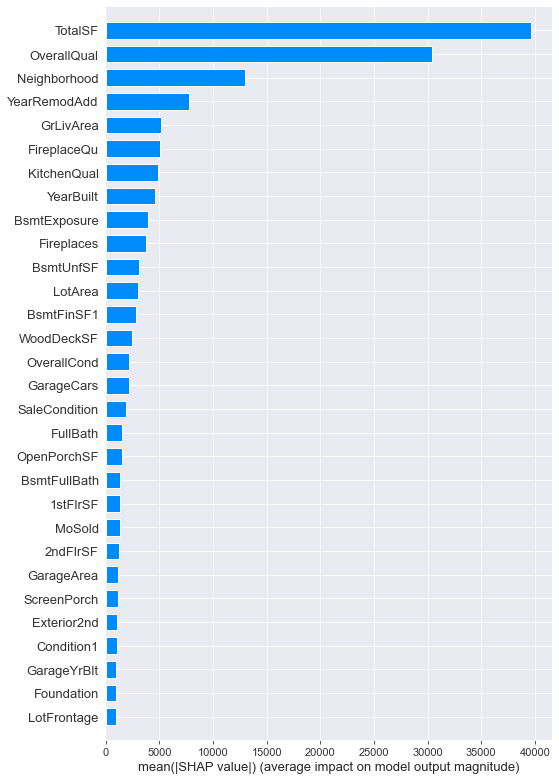

In [23]:
# Feature importance check, just because I can
importances = model.feature_importances_
print ('Feature importances:', np.array(importances))
print ('Feature names:', np.array(train_pool.get_feature_names()))



shap_values = model.get_feature_importance(train_pool, type='ShapValues')
shap.summary_plot(shap_values[:,:-1], X_train, plot_type='bar', max_display=30)

# Prediction and submission

In [24]:
x = model.predict(test_pool)
x

array([120828.169, 161147.673, 189748.974, ..., 159766.574, 111152.359,
       198850.869])

In [25]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = x
sub.to_csv('submission1.csv',index=False)

In [26]:
submission = pd.DataFrame({'Id': test_ID,'SalePrice':x})
#save the file to your directory
submission.to_csv('submission.csv',index=False)